In [1]:
import mne.time_frequency
import mne
from ieeg.io import get_data, raw_from_layout
from ieeg.navigate import trial_ieeg, channel_outlier_marker, crop_empty_data, outliers_to_nan
from ieeg.calc.scaling import rescale
import os
from ieeg.timefreq.utils import wavelet_scaleogram, crop_pad
import numpy as np


['D0057', 'D0059', 'D0063', 'D0065', 'D0069', 'D0071', 'D0077']
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-01_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-01_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-01_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-02_d

c:\Users\jz421\Desktop\GlobalLocal\ieeg\io.py:100: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path)
c:\Users\jz421\Desktop\GlobalLocal\ieeg\io.py:100: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\Users\jz421\Desktop\GlobalLocal\ieeg\io.py:100: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path)
c:\Users\jz421\Desktop\GlobalLocal\ieeg\io.py:100: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path)
c:\Users\jz421\Desktop\GlobalLocal\ieeg\io.py:100: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\Users\jz421\Desktop\GlobalLocal\ieeg\io.py:100: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path)
c:\Users\jz421\Desktop\GlobalLocal\ieeg\io.py:100: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path)
c:\Users\jz421\Desktop\GlobalLocal\ieeg\io.py:100: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_acq-01_space-ACPC_electrodes.tsv.


c:\Users\jz421\Desktop\GlobalLocal\ieeg\io.py:100: RuntimeWarning: Omitted 226 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path)
c:\Users\jz421\Desktop\GlobalLocal\ieeg\io.py:100: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path)
c:\Users\jz421\Desktop\GlobalLocal\ieeg\io.py:100: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path)


<RawEDF | sub-D0057_task-GlobalLocal_acq-01_run-01_desc-clean_ieeg.edf, 178 x 8243200 (4025.0 s), ~201 kB, data not loaded>
outlier round 1 channels: ['RAMT8']
outlier round 2 channels: ['RAMT8', 'RPI16']
Reading 0 ... 3219820  =      0.000 ...  1572.178 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.


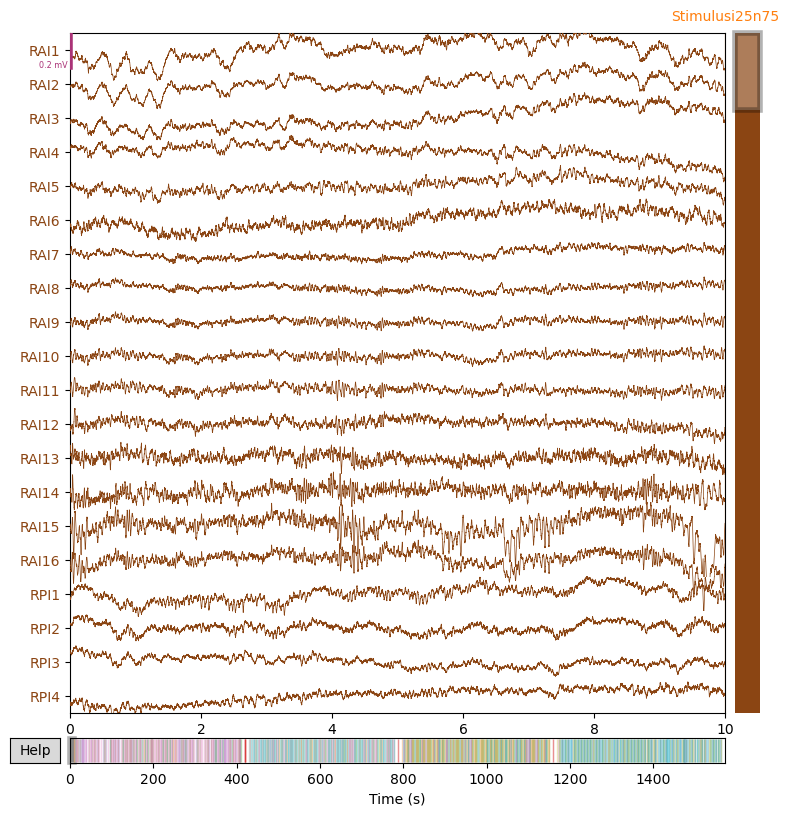

In [43]:
HOME = os.path.expanduser("~")

# get box directory depending on OS
if os.name == 'nt': # windows
    LAB_root = os.path.join(HOME, "Box", "CoganLab")
else: # mac
    LAB_root = os.path.join(HOME, "Library", "CloudStorage", "Box-Box", "CoganLab")

layout = get_data("GlobalLocal", root=LAB_root)
subjects = layout.get(return_type="id", target="subject")

print(subjects)
# for sub in subjects:

sub='D0057' #why does this not work in the for loop???
# Load the data
filt = raw_from_layout(layout.derivatives['derivatives/clean'], subject=sub,
                           extension='.edf', desc='clean', preload=False) #get line-noise filtered data
print(filt)

## Crop raw data to minimize processing time
good = crop_empty_data(filt)

# good.drop_channels(good.info['bads'])
good.info['bads'] = channel_outlier_marker(good, 3, 2)
good.drop_channels(good.info['bads'])
# good.info['bads'] += channel_outlier_marker(good, 4, 2)
# good.drop_channels(good.info['bads'])
good.load_data()

ch_type = filt.get_channel_types(only_data_chs=True)[0]
good.set_eeg_reference(ref_channels="average", ch_type=ch_type)

# Remove intermediates from mem
good.plot()

## epoching and trial outlier removal

save_dir = os.path.join(layout.root, 'derivatives', 'spec', 'wavelet', sub)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


### testing to get avg baseline

In [48]:
baselineShape = 0,176,46,50
stimulusShape = 0,176,46,255
responseShape = 0,176,46,255 #can change these based on the windows


allBaseline = np.empty(shape=(baselineShape))
allStimulus = np.empty(shape=(stimulusShape))
allResponse = np.empty(shape=(responseShape))


for trialType in trialTypes:
    for epoch, t, name in zip(
            ("Stimulus" + trialType, "Stimulus" + trialType, "Response" + trialType),
            ((-0.5, 0), (-0.5, 2), (-0.5, 2)),
            ("baselineStimulus" + trialType, "Stimulus" + trialType, "Response" + trialType)):
        times = [None, None]
        times[0] = t[0] - 0.5
        times[1] = t[1] + 0.5
        trials = trial_ieeg(good, epoch, times, preload=True)
        outliers_to_nan(trials, outliers=10)
        spec = wavelet_scaleogram(trials, n_jobs=-2, decim=int(good.info['sfreq'] / 100))

        crop_pad(spec, "0.5s")
        print(name + ": " + str(spec.data.shape))

        if name == "baselineStimulus" + trialType:
            base = spec.copy()
            allBaselines = np.concatenate([allBaselines, base.data], axis=0)
        elif name == "Stimulus" + trialType:
            allStimulus = np.concatenate([allStimulus, spec.data], axis=0)
        elif name == "Response" + trialType:
            allResponse = np.concatenate([allResponse, spec.data], axis=0)
        else:
            raise NotImplementedError()


Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']


Not setting metadata
23 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 23 events and 3073 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:   10.0s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:   11.8s finished


baselineStimulusi75s25: (23, 176, 46, 50)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
23 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 23 events and 7169 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:   23.8s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:   27.9s finished


Stimulusi75s25: (23, 176, 46, 255)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
23 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 23 events and 7169 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:   24.0s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:   27.8s finished


Responsei75s25: (23, 176, 46, 255)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 4 events and 3073 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:    1.8s


Not setting metadata
baselineStimulusc75s25: (4, 176, 46, 50)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
4 matching events found


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:    2.1s finished


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 4 events and 7169 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:    4.3s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:    5.0s finished


Stimulusc75s25: (4, 176, 46, 255)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 4 events and 7169 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:    4.2s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:    5.0s finished


Responsec75s25: (4, 176, 46, 255)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 60 events and 3073 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:   26.2s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:   30.5s finished


baselineStimulusi75r25: (60, 176, 46, 50)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 60 events and 7169 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:  1.1min


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:  1.2min finished


Stimulusi75r25: (60, 176, 46, 255)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 60 events and 7169 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:  1.1min


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:  1.3min finished


Responsei75r25: (60, 176, 46, 255)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 24 events and 3073 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:   10.5s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:   12.2s finished


baselineStimulusc75r25: (24, 176, 46, 50)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 24 events and 7169 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:   26.2s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:   30.7s finished


Stimulusc75r25: (24, 176, 46, 255)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 24 events and 7169 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:   26.7s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:   31.2s finished


Responsec75r25: (24, 176, 46, 255)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
66 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 66 events and 3073 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:   30.3s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:   35.3s finished


baselineStimulusi75s75: (66, 176, 46, 50)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
66 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 66 events and 7169 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:  1.1min


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:  1.3min finished


Stimulusi75s75: (66, 176, 46, 255)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
66 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 66 events and 7169 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:  1.1min


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:  1.3min finished


Responsei75s75: (66, 176, 46, 255)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 17 events and 3073 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:    6.9s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:    8.2s finished


baselineStimulusc75s75: (17, 176, 46, 50)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 17 events and 7169 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:   16.9s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:   19.8s finished


Stimulusc75s75: (17, 176, 46, 255)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 17 events and 7169 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:   17.0s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:   20.0s finished


Responsec75s75: (17, 176, 46, 255)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 17 events and 3073 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:    7.1s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:    8.3s finished


baselineStimulusi75r75: (17, 176, 46, 50)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 17 events and 7169 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:   16.6s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:   19.9s finished


Stimulusi75r75: (17, 176, 46, 255)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 17 events and 7169 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:   17.4s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:   20.3s finished


Responsei75r75: (17, 176, 46, 255)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 3073 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:    4.8s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:    5.9s finished


baselineStimulusc75r75: (11, 176, 46, 50)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 7169 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:   12.6s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:   14.4s finished


Stimulusc75r75: (11, 176, 46, 255)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 7169 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:   11.2s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:   13.0s finished


Responsec75r75: (11, 176, 46, 255)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 7 events and 3073 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:    2.9s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:    3.6s finished


baselineStimulusi25s25: (7, 176, 46, 50)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 7 events and 7169 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:    7.0s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:    8.2s finished


Stimulusi25s25: (7, 176, 46, 255)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 7 events and 7169 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:    7.0s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:    8.2s finished


Responsei25s25: (7, 176, 46, 255)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 3073 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:    8.6s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:   10.1s finished


baselineStimulusc25s25: (20, 176, 46, 50)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 7169 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:   20.2s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:   23.7s finished


Stimulusc25s25: (20, 176, 46, 255)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 7169 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:   20.1s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:   23.4s finished


Responsec25s25: (20, 176, 46, 255)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 3073 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:    8.9s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:   10.4s finished


baselineStimulusi25r25: (21, 176, 46, 50)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 7169 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:   21.9s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:   25.4s finished


Stimulusi25r25: (21, 176, 46, 255)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 7169 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:   22.1s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:   25.7s finished


Responsei25r25: (21, 176, 46, 255)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 3073 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:   26.8s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:   31.8s finished


baselineStimulusc25r25: (63, 176, 46, 50)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 7169 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:  1.1min


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:  1.3min finished


Stimulusc25r25: (63, 176, 46, 255)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 7169 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:  1.1min


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:  1.3min finished


Responsec25r25: (63, 176, 46, 255)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
23 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 23 events and 3073 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:    9.9s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:   11.7s finished


baselineStimulusi75s25: (23, 176, 46, 50)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
23 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 23 events and 7169 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:   23.0s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:   27.0s finished


Stimulusi75s25: (23, 176, 46, 255)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
23 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 23 events and 7169 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:   22.8s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:   26.9s finished


Responsei75s25: (23, 176, 46, 255)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 61 events and 3073 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:   26.3s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:   30.8s finished


baselineStimulusc25s75: (61, 176, 46, 50)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 61 events and 7169 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:   56.3s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:  1.1min


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:  1.2min finished


Stimulusc25s75: (61, 176, 46, 255)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
55 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 55 events and 7169 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:   56.4s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:  1.1min finished


Responsec25s75: (55, 176, 46, 255)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 5 events and 3073 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:    2.0s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:    2.4s finished


baselineStimulusi25r75: (5, 176, 46, 50)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 5 events and 7169 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:    4.8s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:    5.7s finished


Stimulusi25r75: (5, 176, 46, 255)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 3 events and 7169 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:    3.0s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:    3.5s finished


Responsei25r75: (3, 176, 46, 255)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
23 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 23 events and 3073 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:    9.6s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:   11.1s finished


baselineStimulusc25r75: (23, 176, 46, 50)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
23 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 23 events and 7169 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:   23.6s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:   27.6s finished


Stimulusc25r75: (23, 176, 46, 255)
Used Annotations descriptions: ['Responsec25n25', 'Responsec25r25', 'Responsec25r75', 'Responsec25s25', 'Responsec25s75', 'Responsec75r25', 'Responsec75r75', 'Responsec75s25', 'Responsec75s75', 'Responsei25r25', 'Responsei25r75', 'Responsei25s25', 'Responsei25s75', 'Responsei75n25', 'Responsei75n75', 'Responsei75r25', 'Responsei75r75', 'Responsei75s25', 'Responsei75s75', 'Stimulusc25n25', 'Stimulusc25r25', 'Stimulusc25r75', 'Stimulusc25s25', 'Stimulusc25s75', 'Stimulusc75r25', 'Stimulusc75r75', 'Stimulusc75s25', 'Stimulusc75s75', 'Stimulusi25n75', 'Stimulusi25r25', 'Stimulusi25r75', 'Stimulusi25s25', 'Stimulusi25s75', 'Stimulusi75n25', 'Stimulusi75n75', 'Stimulusi75r25', 'Stimulusi75r75', 'Stimulusi75s25', 'Stimulusi75s75']
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 7169 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:   23.6s


Not setting metadata


[Parallel(n_jobs=-2)]: Done 176 out of 176 | elapsed:   28.0s finished


Responsec25r75: (22, 176, 46, 255)


### do rescale for ALL stimuli

In [54]:
base.data = allBaseline
spec.data = allStimulus #uhhhh does it matter which spec we use? any random wavelet will do?
spec_a = rescale(spec, base, copy=True, mode='ratio').average(lambda x: np.nanmean(x, axis=0), copy=True)
    
spec_a._data = np.log10(spec_a._data) * 20
fnames = [os.path.relpath(f, layout.root) for f in good.filenames]
spec_a.info['subject_info']['files'] = tuple(fnames)
spec_a.info['bads'] = good.info['bads']
filename = os.path.join(save_dir, 'AvgAllStimulusAllBaseline.h5')
mne.time_frequency.write_tfrs(filename, spec_a, overwrite=True)
spec_a.save(os.path.join(save_dir, 'AvgAllStimulusAllBaseline.fif'), overwrite=True)

Applying baseline correction (mode: ratio)


### do rescale for ALL responses

In [55]:
base.data = allBaseline
spec.data = allResponse
spec_a = rescale(spec, base, copy=True, mode='ratio').average(lambda x: np.nanmean(x, axis=0), copy=True)
    
spec_a._data = np.log10(spec_a._data) * 20
fnames = [os.path.relpath(f, layout.root) for f in good.filenames]
spec_a.info['subject_info']['files'] = tuple(fnames)
spec_a.info['bads'] = good.info['bads']
filename = os.path.join(save_dir, 'AvgAllResponseAllBaseline.h5')
mne.time_frequency.write_tfrs(filename, spec_a, overwrite=True)
spec_a.save(os.path.join(save_dir, 'AvgAllResponseAllBaseline.fif'), overwrite=True)

Applying baseline correction (mode: ratio)


### do rescale for all conditions individually with an averaged baseline

In [ ]:
# Rescale all the specs after baselines are concatenated
for trialType in trialTypes:
    for epoch, t, name in zip(
            ("Stimulus"+trialType, "Stimulus"+trialType, "Response"+trialType),
            ((-0.5, 0), (-0.5, 2), (-1, 2)),
            ("baselineStimulus"+trialType, "Stimulus"+trialType, "Response"+trialType)):
        times = [None, None]
        times[0] = t[0] - 0.5
        times[1] = t[1] + 0.5
        trials = trial_ieeg(good, epoch, times, preload=True)
        outliers_to_nan(trials, outliers=10)
        spec = wavelet_scaleogram(trials, n_jobs=-2, decim=int(good.info['sfreq'] / 100))
        print(trialType + ": " + str(spec.data.shape))
        timeDim = spec.data.shape[3]
        if timeDim > biggestTimeDim:
            biggestTimeDim = timeDim
        crop_pad(spec, "0.5s")
        if name == "baselineStimulus"+trialType:
            continue
        base = spec.copy()
        base.data = allBaselines
        spec_a = rescale(spec, base, copy=True, mode='ratio').average(
            lambda x: np.nanmean(x, axis=0), copy=True)
        spec_a._data = np.log10(spec_a._data) * 20
        fnames = [os.path.relpath(f, layout.root) for f in good.filenames]
        spec_a.info['subject_info']['files'] = tuple(fnames)
        spec_a.info['bads'] = good.info['bads']
        filename = os.path.join(save_dir, f'{name}-tfrAvgAllBaseline.h5')
        mne.time_frequency.write_tfrs(filename, spec_a, overwrite=True)
        spec_a.save(os.path.join(save_dir, f'{name}-avgAvgAllBaseline.fif'), overwrite=True)


### for a single trial type
this is old and broken, delete once the others work

In [ ]:
# trialType = "i75s25"
trialTypes = ["i75s25", "c75s25", "i75r25", "c75r25", "i75s75", "c75s75", "i75r75", "c75r75",
              "i25s25", "c25s25", "i25r25", "c25r25", "i75s25", "c25s75", "i25r75", "c25r75"]

allBaselines = np.empty(shape=(0,176,46,50))


for trialType in trialTypes:
    for epoch, t, name in zip(
        ("Stimulus"+trialType, "Stimulus"+trialType,  "Response"+trialType),
        ((-0.5, 0), (-0.5, 2), (-1, 2)),
        ("baselineStimulus"+trialType, "Stimulus"+trialType, "Response"+trialType)):
        times = [None, None]
        times[0] = t[0] - 0.5
        times[1] = t[1] + 0.5
        trials = trial_ieeg(good, epoch, times, preload=True)
        outliers_to_nan(trials, outliers=10)
        spec = wavelet_scaleogram(trials, n_jobs=-2, decim=int(
            good.info['sfreq'] / 100))
        crop_pad(spec, "0.5s")
        if name == "baselineStimulus"+trialType:
            base = spec.copy()
            continue
            
        spec_a = rescale(spec, base, copy=True, mode='ratio').average(
            lambda x: np.nanmean(x, axis=0), copy=True)
        spec_a._data = np.log10(spec_a._data) * 20
        fnames = [os.path.relpath(f, layout.root) for f in good.filenames]
        spec_a.info['subject_info']['files'] = tuple(fnames)
        spec_a.info['bads'] = good.info['bads']
        filename = os.path.join(save_dir, f'{name}-tfr.h5')
        mne.time_frequency.write_tfrs(filename, spec_a, overwrite=True)
        spec_a.save(os.path.join(save_dir, f'{name}-avg.fif'), overwrite=True)
